# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

老师写的NN的版本对于不熟悉class，从来没写过class的我实在太难了，基本复现不出来，只能大致上记一下思路和其中个人觉得比较难想到的地方，并且复习一下class的基本概念，在code 里加了一些我自己的理解和批注，如果助教老师看到有不对的地方，请帮我指出，谢谢。

老师 NNcode的基本思路：<br>
* Define a Node class with forward and backward function.<br>
    self.gradients = {}<br>
    keys are the inputs to this node, and their <br>
    values are the partials of this node with respect to that input: \partial{node}{input_i}
    #gradients这个dict里面 key 存的就是本节点所有输入节点的对象，然后values 存的就是本节点的梯度对于那个输入节点的导数 
        
* Define Input, Add, linear, sigmoid, MSE classes. Those are all Node class with their own forward and backward functions.
* Define a topological_sort function to sort all the nodes (inputs) in the NN. All innputs and Nodes are saved in graph list [b2, w2, x1, w1, b1, linear1, sigmoide 1, linear2, MSE] 


* 类中自带的函数和变量都是以下划线_开头的
* inputs, outputs, value, gradients 都是这个Node 类的实例变量
* 如果是私有变量会用两个下划线 __ 开头，然后无法从外部访问。 比如a=Node(), a. __  这样子无法调用
* 私有方法是同样的道理，也不能直接从外部访问，而且私有方法必需含有self这个参数，且把它作为第一个参数https://zhuanlan.zhihu.com/p/37145434

In [27]:
import numpy as np

class Node:
    
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        #gradients这个dict里面 key 存的就是本节点所有输入节点的对象，然后values 存的就是本节点的梯度对于那个输入节点的导数 
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        #给self.gradients赋初始值
        self.gradients = {self:0}
        #n是后面的节点，就是从后面节点的gradients里面找到自己的梯度然后复制过来
        for n in self.outputs:
            grad_cost = n.gradients[self]
            #grad_cost=gradients[n]？？？
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]
            # 对X 求导 = W * x自身的倒数
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            # 对 W 求导 = X * X自身的倒数
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
             #对b 求导
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        #sigmoid 函数求导= sigmoid 函数 * （1- sigmoid函数）
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.


class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.
    #graph是一个存了nodes的lists，是经过拓扑排序过的一个NN的list，前面的点排在前面，后面的排在后面

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        #graph[::-1]把整个list 反过来
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """
    ##拓扑排序： 每一个点有入度和出度，当一个点的入度为0的时候就可以放到一个list里也就是上面的graph

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [65]:
from sklearn.datasets import load_boston
data = load_boston()
losses = []
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)
#归一化使得X 的影响程度类似，而不是某一个X dorminate 

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
print ('W1 shape:', W1_.shape)
b1_ = np.zeros(n_hidden)
print ('b1 shape:', b1_.shape)
W2_ = np.random.randn(n_hidden, 1)
print ('W2_ shape :', W2_.shape)
b2_ = np.zeros(1)
print ('b2_ shape:', b2_.shape)

print ('X_ shape:', (X_.shape))
print ('y_ shape:', (y_.shape))
print (np.max(X_), np.min(X_))

W1 shape: (13, 10)
b1 shape: (10,)
W2_ shape : (10, 1)
b2_ shape: (1,)
X_ shape: (506, 13)
y_ shape: (506,)
9.933930601860268 -3.9071933049810337


In [29]:
# Neural network
#一开始这些都是input
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

#（x*w1+b1 linear转换 -> sigmoid）*w2+b2 linear 转换-> MSE
#拓扑排序完之后是[b2, w2, x1, w1, b1, linear1, sigmoide 1, linear2, MSE]

In [30]:
#初始化
feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

#把所有节点放到graph里进行拓扑排序
graph = topological_sort(feed_dict)
#然后需要训练的是下面四个
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.
        #我们不需要每个node 的output 所以用_代表，我们只需要estimate出来的parameters

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 152.588
Epoch: 101, Loss: 7.271
Epoch: 201, Loss: 5.905
Epoch: 301, Loss: 4.982
Epoch: 401, Loss: 4.571
Epoch: 501, Loss: 5.518
Epoch: 601, Loss: 4.098
Epoch: 701, Loss: 3.865
Epoch: 801, Loss: 4.231
Epoch: 901, Loss: 3.942
Epoch: 1001, Loss: 3.667
Epoch: 1101, Loss: 3.936
Epoch: 1201, Loss: 3.362
Epoch: 1301, Loss: 3.409
Epoch: 1401, Loss: 4.044
Epoch: 1501, Loss: 3.814
Epoch: 1601, Loss: 3.347
Epoch: 1701, Loss: 3.504
Epoch: 1801, Loss: 3.827
Epoch: 1901, Loss: 4.071
Epoch: 2001, Loss: 4.108
Epoch: 2101, Loss: 3.367
Epoch: 2201, Loss: 3.080
Epoch: 2301, Loss: 3.440
Epoch: 2401, Loss: 3.432
Epoch: 2501, Loss: 2.765
Epoch: 2601, Loss: 3.349
Epoch: 2701, Loss: 3.129
Epoch: 2801, Loss: 4.205
Epoch: 2901, Loss: 3.133
Epoch: 3001, Loss: 3.391
Epoch: 3101, Loss: 3.175
Epoch: 3201, Loss: 3.616
Epoch: 3301, Loss: 2.990
Epoch: 3401, Loss: 3.099
Epoch: 3501, Loss: 3.373
Epoch: 3601, Loss: 3.124
Epoch: 3701, Loss: 3.504
Epoch: 3801, Loss: 3.076
Epoc

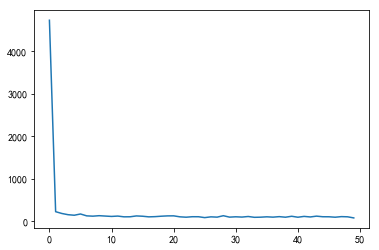

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(losses)), losses)

In [32]:
W2.value

array([[ 6.26676485],
       [ 6.14988015],
       [ 8.54883863],
       [ 5.94647105],
       [11.47045782],
       [10.75365464],
       [ 6.40017469],
       [-3.89776628],
       [20.6546239 ],
       [ 8.40540009]])

In [33]:
## 也可以用foward 输出计算的l1 或者l2这些middle step 的nodes
def forward (outputNode, graph):
    for n in graph:
        n.forward()
    return outputNode.value
print(forward(l1,graph))
print (forward(l2,graph))

[[-7.93839136e+00  5.96188612e+00  1.34058922e+01  8.29406172e+00
   9.84154857e-02 -2.96557842e+00  1.67637816e+01 -2.16023683e+01
  -1.00736688e+01  7.43763597e+00]
 [-2.27231172e+01  4.67116534e+00  4.46457106e+01  5.15950559e+00
   1.87719829e+00 -4.90577058e+00  3.11393801e+01 -3.36305983e+01
  -6.76279780e+00  1.54641830e+01]
 [-1.10335116e+01 -2.59349686e+00  4.09612520e+01 -1.06240749e+01
  -6.44912180e+00 -4.61664986e+00  3.36580020e+01 -1.81744898e+01
  -2.25849801e+01  3.69258886e+00]
 [ 1.49406743e+01 -1.32859593e+01  4.62925417e+00 -7.64292388e+00
  -5.54863324e+00 -3.29744301e+00  1.82406151e+01 -7.10163931e-01
  -2.61518412e+01 -5.44010882e+00]
 [-4.34189316e+00 -1.57628183e+01  4.76915023e+00 -4.33423182e+00
  -7.79812710e+00  5.09333302e-01  1.38829729e+01 -4.72681016e+00
  -1.15012198e+01 -5.42784725e+00]
 [-3.25629444e+00 -2.21215973e+01  6.48614949e+00  3.29022922e+00
  -1.88458248e+01  5.08675797e+00 -7.73262668e+00  3.92274501e+00
  -1.25601494e+01 -1.06583367e+01

### 用kerea 实现第一层 64 个nodes  ， 第二层30个nodes， output层一个node （因为是regression 问题
### 要注意的是X必须要先归一化，不然NN loss完全不变，predict的值完全都是一样的

In [34]:
import warnings
warnings.filterwarnings("ignore")

X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 0s 780us/step - loss: 142.8534 - mean_squared_error: 142.8534
Epoch 2/5000
506/506 [==============================] - 0s 38us/step - loss: 63.0839 - mean_squared_error: 63.0839
Epoch 3/5000
506/506 [==============================] - 0s 53us/step - loss: 48.1711 - mean_squared_error: 48.1711
Epoch 4/5000
506/506 [==============================] - 0s 42us/step - loss: 39.4274 - mean_squared_error: 39.4274
Epoch 5/5000
506/506 [==============================] - 0s 45us/step - loss: 31.1411 - mean_squared_error: 31.1411
Epoch 6/5000
506/506 [==============================] - 0s 41us/step - loss: 27.0112 - mean_squared_error: 27.0112
Epoch 7/5000
506/506 [==============================] - 0s 38us/step - loss: 25.2341 - mean_squared_error: 25.2341
Epoch 8/5000
506/506 [==============================] - 0s 36us/step - loss: 23.5429 - mean_squared_error: 23.5429
Epoch 9/5000
506/506 [==============================] - 0s 37us/step - loss: 

506/506 [==============================] - 0s 36us/step - loss: 10.1395 - mean_squared_error: 10.1395
Epoch 72/5000
506/506 [==============================] - 0s 38us/step - loss: 10.1564 - mean_squared_error: 10.1564
Epoch 73/5000
506/506 [==============================] - 0s 32us/step - loss: 10.1437 - mean_squared_error: 10.1437
Epoch 74/5000
506/506 [==============================] - 0s 33us/step - loss: 10.5610 - mean_squared_error: 10.5610
Epoch 75/5000
506/506 [==============================] - 0s 32us/step - loss: 9.8625 - mean_squared_error: 9.8625
Epoch 76/5000
506/506 [==============================] - 0s 31us/step - loss: 9.9951 - mean_squared_error: 9.9951
Epoch 77/5000
506/506 [==============================] - 0s 32us/step - loss: 10.1870 - mean_squared_error: 10.1870
Epoch 78/5000
506/506 [==============================] - 0s 33us/step - loss: 9.7583 - mean_squared_error: 9.7583
Epoch 79/5000
506/506 [==============================] - 0s 33us/step - loss: 9.9186 - mean_

506/506 [==============================] - 0s 34us/step - loss: 7.3152 - mean_squared_error: 7.3152
Epoch 143/5000
506/506 [==============================] - 0s 37us/step - loss: 7.3828 - mean_squared_error: 7.3828
Epoch 144/5000
506/506 [==============================] - 0s 34us/step - loss: 7.0912 - mean_squared_error: 7.0912
Epoch 145/5000
506/506 [==============================] - 0s 34us/step - loss: 7.0551 - mean_squared_error: 7.0551
Epoch 146/5000
506/506 [==============================] - 0s 33us/step - loss: 6.9975 - mean_squared_error: 6.9975
Epoch 147/5000
506/506 [==============================] - 0s 35us/step - loss: 6.8960 - mean_squared_error: 6.8960
Epoch 148/5000
506/506 [==============================] - 0s 35us/step - loss: 7.1588 - mean_squared_error: 7.1588
Epoch 149/5000
506/506 [==============================] - 0s 32us/step - loss: 6.9089 - mean_squared_error: 6.9089
Epoch 150/5000
506/506 [==============================] - 0s 33us/step - loss: 6.9531 - mean_sq

506/506 [==============================] - 0s 33us/step - loss: 5.2919 - mean_squared_error: 5.2919
Epoch 214/5000
506/506 [==============================] - 0s 34us/step - loss: 5.4754 - mean_squared_error: 5.4754
Epoch 215/5000
506/506 [==============================] - 0s 32us/step - loss: 5.2194 - mean_squared_error: 5.2194
Epoch 216/5000
506/506 [==============================] - 0s 35us/step - loss: 5.4960 - mean_squared_error: 5.4960
Epoch 217/5000
506/506 [==============================] - 0s 33us/step - loss: 5.2885 - mean_squared_error: 5.2885
Epoch 218/5000
506/506 [==============================] - 0s 33us/step - loss: 5.2468 - mean_squared_error: 5.2468
Epoch 219/5000
506/506 [==============================] - 0s 32us/step - loss: 5.3629 - mean_squared_error: 5.3629
Epoch 220/5000
506/506 [==============================] - 0s 33us/step - loss: 5.1306 - mean_squared_error: 5.1306
Epoch 221/5000
506/506 [==============================] - 0s 33us/step - loss: 5.2912 - mean_sq

506/506 [==============================] - 0s 32us/step - loss: 4.3842 - mean_squared_error: 4.3842
Epoch 285/5000
506/506 [==============================] - 0s 33us/step - loss: 4.5885 - mean_squared_error: 4.5885
Epoch 286/5000
506/506 [==============================] - 0s 33us/step - loss: 4.3224 - mean_squared_error: 4.3224
Epoch 287/5000
506/506 [==============================] - 0s 32us/step - loss: 4.4794 - mean_squared_error: 4.4794
Epoch 288/5000
506/506 [==============================] - 0s 36us/step - loss: 4.4492 - mean_squared_error: 4.4492
Epoch 289/5000
506/506 [==============================] - 0s 35us/step - loss: 4.3309 - mean_squared_error: 4.3309
Epoch 290/5000
506/506 [==============================] - 0s 35us/step - loss: 4.4919 - mean_squared_error: 4.4919
Epoch 291/5000
506/506 [==============================] - 0s 35us/step - loss: 4.4898 - mean_squared_error: 4.4898
Epoch 292/5000
506/506 [==============================] - 0s 34us/step - loss: 4.4093 - mean_sq

506/506 [==============================] - 0s 35us/step - loss: 4.0097 - mean_squared_error: 4.0097
Epoch 356/5000
506/506 [==============================] - 0s 36us/step - loss: 4.0538 - mean_squared_error: 4.0538
Epoch 357/5000
506/506 [==============================] - 0s 34us/step - loss: 3.9778 - mean_squared_error: 3.9778
Epoch 358/5000
506/506 [==============================] - 0s 36us/step - loss: 3.8528 - mean_squared_error: 3.8528
Epoch 359/5000
506/506 [==============================] - 0s 36us/step - loss: 4.0476 - mean_squared_error: 4.0476
Epoch 360/5000
506/506 [==============================] - 0s 38us/step - loss: 3.9946 - mean_squared_error: 3.9946
Epoch 361/5000
506/506 [==============================] - 0s 40us/step - loss: 4.1274 - mean_squared_error: 4.1274
Epoch 362/5000
506/506 [==============================] - 0s 39us/step - loss: 3.8974 - mean_squared_error: 3.8974
Epoch 363/5000
506/506 [==============================] - 0s 34us/step - loss: 3.7816 - mean_sq

506/506 [==============================] - 0s 33us/step - loss: 3.4751 - mean_squared_error: 3.4751
Epoch 427/5000
506/506 [==============================] - 0s 33us/step - loss: 3.4565 - mean_squared_error: 3.4565
Epoch 428/5000
506/506 [==============================] - 0s 33us/step - loss: 3.4051 - mean_squared_error: 3.4051
Epoch 429/5000
506/506 [==============================] - 0s 33us/step - loss: 3.4504 - mean_squared_error: 3.4504
Epoch 430/5000
506/506 [==============================] - 0s 32us/step - loss: 3.3505 - mean_squared_error: 3.3505
Epoch 431/5000
506/506 [==============================] - 0s 32us/step - loss: 3.3033 - mean_squared_error: 3.3033
Epoch 432/5000
506/506 [==============================] - 0s 33us/step - loss: 3.4327 - mean_squared_error: 3.4327
Epoch 433/5000
506/506 [==============================] - 0s 33us/step - loss: 3.2950 - mean_squared_error: 3.2950
Epoch 434/5000
506/506 [==============================] - 0s 32us/step - loss: 3.3019 - mean_sq

506/506 [==============================] - 0s 33us/step - loss: 3.0027 - mean_squared_error: 3.0027
Epoch 498/5000
506/506 [==============================] - 0s 33us/step - loss: 3.1006 - mean_squared_error: 3.1006
Epoch 499/5000
506/506 [==============================] - 0s 33us/step - loss: 3.0474 - mean_squared_error: 3.0474
Epoch 500/5000
506/506 [==============================] - 0s 33us/step - loss: 2.9563 - mean_squared_error: 2.9563
Epoch 501/5000
506/506 [==============================] - 0s 34us/step - loss: 3.1036 - mean_squared_error: 3.1036
Epoch 502/5000
506/506 [==============================] - 0s 34us/step - loss: 2.9385 - mean_squared_error: 2.9385
Epoch 503/5000
506/506 [==============================] - 0s 35us/step - loss: 2.9828 - mean_squared_error: 2.9828
Epoch 504/5000
506/506 [==============================] - 0s 35us/step - loss: 3.0333 - mean_squared_error: 3.0333
Epoch 505/5000
506/506 [==============================] - 0s 35us/step - loss: 2.9753 - mean_sq

506/506 [==============================] - 0s 36us/step - loss: 2.6326 - mean_squared_error: 2.6326
Epoch 569/5000
506/506 [==============================] - 0s 39us/step - loss: 2.6720 - mean_squared_error: 2.6720
Epoch 570/5000
506/506 [==============================] - 0s 49us/step - loss: 2.6551 - mean_squared_error: 2.6551
Epoch 571/5000
506/506 [==============================] - 0s 48us/step - loss: 2.6104 - mean_squared_error: 2.6104
Epoch 572/5000
506/506 [==============================] - 0s 45us/step - loss: 2.6421 - mean_squared_error: 2.6421
Epoch 573/5000
506/506 [==============================] - 0s 36us/step - loss: 2.6412 - mean_squared_error: 2.6412
Epoch 574/5000
506/506 [==============================] - 0s 37us/step - loss: 2.7148 - mean_squared_error: 2.7148
Epoch 575/5000
506/506 [==============================] - 0s 36us/step - loss: 2.6879 - mean_squared_error: 2.6879
Epoch 576/5000
506/506 [==============================] - 0s 38us/step - loss: 2.5750 - mean_sq

506/506 [==============================] - 0s 34us/step - loss: 2.4102 - mean_squared_error: 2.4102
Epoch 640/5000
506/506 [==============================] - 0s 34us/step - loss: 2.4029 - mean_squared_error: 2.4029
Epoch 641/5000
506/506 [==============================] - 0s 33us/step - loss: 2.3882 - mean_squared_error: 2.3882
Epoch 642/5000
506/506 [==============================] - 0s 32us/step - loss: 2.3597 - mean_squared_error: 2.3597
Epoch 643/5000
506/506 [==============================] - 0s 34us/step - loss: 2.3323 - mean_squared_error: 2.3323
Epoch 644/5000
506/506 [==============================] - 0s 33us/step - loss: 2.3764 - mean_squared_error: 2.3764
Epoch 645/5000
506/506 [==============================] - 0s 32us/step - loss: 2.3413 - mean_squared_error: 2.3413
Epoch 646/5000
506/506 [==============================] - 0s 35us/step - loss: 2.4305 - mean_squared_error: 2.4305
Epoch 647/5000
506/506 [==============================] - 0s 32us/step - loss: 2.3377 - mean_sq

506/506 [==============================] - 0s 33us/step - loss: 2.1473 - mean_squared_error: 2.1473
Epoch 711/5000
506/506 [==============================] - 0s 34us/step - loss: 2.1115 - mean_squared_error: 2.1115
Epoch 712/5000
506/506 [==============================] - 0s 33us/step - loss: 2.0662 - mean_squared_error: 2.0662
Epoch 713/5000
506/506 [==============================] - 0s 33us/step - loss: 2.0923 - mean_squared_error: 2.0923
Epoch 714/5000
506/506 [==============================] - 0s 33us/step - loss: 2.0513 - mean_squared_error: 2.0513
Epoch 715/5000
506/506 [==============================] - 0s 33us/step - loss: 2.3446 - mean_squared_error: 2.3446
Epoch 716/5000
506/506 [==============================] - 0s 32us/step - loss: 2.0742 - mean_squared_error: 2.0742
Epoch 717/5000
506/506 [==============================] - 0s 33us/step - loss: 2.0808 - mean_squared_error: 2.0808
Epoch 718/5000
506/506 [==============================] - 0s 33us/step - loss: 2.0689 - mean_sq

506/506 [==============================] - 0s 32us/step - loss: 1.8745 - mean_squared_error: 1.8745
Epoch 782/5000
506/506 [==============================] - 0s 37us/step - loss: 1.9546 - mean_squared_error: 1.9546
Epoch 783/5000
506/506 [==============================] - 0s 40us/step - loss: 1.9670 - mean_squared_error: 1.9670
Epoch 784/5000
506/506 [==============================] - 0s 41us/step - loss: 1.8997 - mean_squared_error: 1.8997
Epoch 785/5000
506/506 [==============================] - 0s 34us/step - loss: 1.9485 - mean_squared_error: 1.9485
Epoch 786/5000
506/506 [==============================] - 0s 33us/step - loss: 1.8417 - mean_squared_error: 1.8417
Epoch 787/5000
506/506 [==============================] - 0s 33us/step - loss: 1.8901 - mean_squared_error: 1.8901
Epoch 788/5000
506/506 [==============================] - 0s 33us/step - loss: 1.9662 - mean_squared_error: 1.9662
Epoch 789/5000
506/506 [==============================] - 0s 33us/step - loss: 1.9289 - mean_sq

506/506 [==============================] - 0s 33us/step - loss: 1.7287 - mean_squared_error: 1.7287
Epoch 853/5000
506/506 [==============================] - 0s 34us/step - loss: 1.7356 - mean_squared_error: 1.7356
Epoch 854/5000
506/506 [==============================] - 0s 33us/step - loss: 1.8637 - mean_squared_error: 1.8637
Epoch 855/5000
506/506 [==============================] - 0s 32us/step - loss: 1.6777 - mean_squared_error: 1.6777
Epoch 856/5000
506/506 [==============================] - 0s 33us/step - loss: 1.7609 - mean_squared_error: 1.7609
Epoch 857/5000
506/506 [==============================] - 0s 32us/step - loss: 1.7994 - mean_squared_error: 1.7994
Epoch 858/5000
506/506 [==============================] - 0s 32us/step - loss: 1.8801 - mean_squared_error: 1.8801
Epoch 859/5000
506/506 [==============================] - 0s 33us/step - loss: 1.7683 - mean_squared_error: 1.7683
Epoch 860/5000
506/506 [==============================] - 0s 33us/step - loss: 1.6551 - mean_sq

506/506 [==============================] - 0s 35us/step - loss: 1.7150 - mean_squared_error: 1.7150
Epoch 924/5000
506/506 [==============================] - 0s 36us/step - loss: 1.6025 - mean_squared_error: 1.6025
Epoch 925/5000
506/506 [==============================] - 0s 36us/step - loss: 1.6734 - mean_squared_error: 1.6734
Epoch 926/5000
506/506 [==============================] - 0s 36us/step - loss: 1.5867 - mean_squared_error: 1.5867
Epoch 927/5000
506/506 [==============================] - 0s 36us/step - loss: 1.5587 - mean_squared_error: 1.5587
Epoch 928/5000
506/506 [==============================] - 0s 35us/step - loss: 1.5930 - mean_squared_error: 1.5930
Epoch 929/5000
506/506 [==============================] - 0s 35us/step - loss: 1.6553 - mean_squared_error: 1.6553
Epoch 930/5000
506/506 [==============================] - 0s 34us/step - loss: 1.5304 - mean_squared_error: 1.5304
Epoch 931/5000
506/506 [==============================] - 0s 36us/step - loss: 1.5383 - mean_sq

506/506 [==============================] - 0s 38us/step - loss: 1.4267 - mean_squared_error: 1.4267
Epoch 995/5000
506/506 [==============================] - 0s 37us/step - loss: 1.4736 - mean_squared_error: 1.4736
Epoch 996/5000
506/506 [==============================] - 0s 36us/step - loss: 1.6047 - mean_squared_error: 1.6047
Epoch 997/5000
506/506 [==============================] - 0s 36us/step - loss: 1.5111 - mean_squared_error: 1.5111
Epoch 998/5000
506/506 [==============================] - 0s 36us/step - loss: 1.4886 - mean_squared_error: 1.4886
Epoch 999/5000
506/506 [==============================] - 0s 36us/step - loss: 1.4748 - mean_squared_error: 1.4748
Epoch 1000/5000
506/506 [==============================] - 0s 34us/step - loss: 1.4707 - mean_squared_error: 1.4707
Epoch 1001/5000
506/506 [==============================] - 0s 34us/step - loss: 1.5602 - mean_squared_error: 1.5602
Epoch 1002/5000
506/506 [==============================] - 0s 34us/step - loss: 1.4667 - mean

506/506 [==============================] - 0s 36us/step - loss: 1.4642 - mean_squared_error: 1.4642
Epoch 1065/5000
506/506 [==============================] - 0s 36us/step - loss: 1.4107 - mean_squared_error: 1.4107
Epoch 1066/5000
506/506 [==============================] - 0s 33us/step - loss: 1.4014 - mean_squared_error: 1.4014
Epoch 1067/5000
506/506 [==============================] - 0s 33us/step - loss: 1.3890 - mean_squared_error: 1.3890
Epoch 1068/5000
506/506 [==============================] - 0s 33us/step - loss: 1.4088 - mean_squared_error: 1.4088
Epoch 1069/5000
506/506 [==============================] - 0s 35us/step - loss: 1.3868 - mean_squared_error: 1.3868
Epoch 1070/5000
506/506 [==============================] - 0s 33us/step - loss: 1.6545 - mean_squared_error: 1.6545
Epoch 1071/5000
506/506 [==============================] - 0s 33us/step - loss: 1.5089 - mean_squared_error: 1.5089
Epoch 1072/5000
506/506 [==============================] - 0s 32us/step - loss: 1.4181 -

506/506 [==============================] - 0s 42us/step - loss: 1.3025 - mean_squared_error: 1.3025
Epoch 1135/5000
506/506 [==============================] - 0s 39us/step - loss: 1.3725 - mean_squared_error: 1.3725
Epoch 1136/5000
506/506 [==============================] - 0s 34us/step - loss: 1.2538 - mean_squared_error: 1.2538
Epoch 1137/5000
506/506 [==============================] - 0s 32us/step - loss: 1.2821 - mean_squared_error: 1.2821
Epoch 1138/5000
506/506 [==============================] - 0s 32us/step - loss: 1.2795 - mean_squared_error: 1.2795
Epoch 1139/5000
506/506 [==============================] - 0s 33us/step - loss: 1.3028 - mean_squared_error: 1.3028
Epoch 1140/5000
506/506 [==============================] - 0s 33us/step - loss: 1.3991 - mean_squared_error: 1.3991
Epoch 1141/5000
506/506 [==============================] - 0s 41us/step - loss: 1.3221 - mean_squared_error: 1.3221
Epoch 1142/5000
506/506 [==============================] - 0s 41us/step - loss: 1.2702 -

506/506 [==============================] - 0s 34us/step - loss: 1.2022 - mean_squared_error: 1.2022
Epoch 1205/5000
506/506 [==============================] - 0s 39us/step - loss: 1.1496 - mean_squared_error: 1.1496
Epoch 1206/5000
506/506 [==============================] - 0s 42us/step - loss: 1.2652 - mean_squared_error: 1.2652
Epoch 1207/5000
506/506 [==============================] - 0s 34us/step - loss: 1.2400 - mean_squared_error: 1.2400
Epoch 1208/5000
506/506 [==============================] - 0s 36us/step - loss: 1.1999 - mean_squared_error: 1.1999
Epoch 1209/5000
506/506 [==============================] - 0s 38us/step - loss: 1.1965 - mean_squared_error: 1.1965
Epoch 1210/5000
506/506 [==============================] - 0s 34us/step - loss: 1.2052 - mean_squared_error: 1.2052
Epoch 1211/5000
506/506 [==============================] - 0s 36us/step - loss: 1.1520 - mean_squared_error: 1.1520
Epoch 1212/5000
506/506 [==============================] - 0s 38us/step - loss: 1.1786 -

506/506 [==============================] - 0s 44us/step - loss: 1.1062 - mean_squared_error: 1.1062
Epoch 1275/5000
506/506 [==============================] - 0s 36us/step - loss: 1.1540 - mean_squared_error: 1.1540
Epoch 1276/5000
506/506 [==============================] - 0s 34us/step - loss: 1.1420 - mean_squared_error: 1.1420
Epoch 1277/5000
506/506 [==============================] - 0s 34us/step - loss: 1.1378 - mean_squared_error: 1.1378
Epoch 1278/5000
506/506 [==============================] - 0s 33us/step - loss: 1.1448 - mean_squared_error: 1.1448
Epoch 1279/5000
506/506 [==============================] - 0s 33us/step - loss: 1.1413 - mean_squared_error: 1.1413
Epoch 1280/5000
506/506 [==============================] - 0s 33us/step - loss: 1.1596 - mean_squared_error: 1.1596
Epoch 1281/5000
506/506 [==============================] - 0s 38us/step - loss: 1.0725 - mean_squared_error: 1.0725
Epoch 1282/5000
506/506 [==============================] - 0s 35us/step - loss: 1.1582 -

506/506 [==============================] - 0s 34us/step - loss: 1.0372 - mean_squared_error: 1.0372
Epoch 1345/5000
506/506 [==============================] - 0s 33us/step - loss: 1.0256 - mean_squared_error: 1.0256
Epoch 1346/5000
506/506 [==============================] - 0s 33us/step - loss: 1.0970 - mean_squared_error: 1.0970
Epoch 1347/5000
506/506 [==============================] - 0s 33us/step - loss: 1.1654 - mean_squared_error: 1.1654
Epoch 1348/5000
506/506 [==============================] - 0s 33us/step - loss: 1.0387 - mean_squared_error: 1.0387
Epoch 1349/5000
506/506 [==============================] - 0s 33us/step - loss: 1.1356 - mean_squared_error: 1.1356
Epoch 1350/5000
506/506 [==============================] - 0s 33us/step - loss: 1.0839 - mean_squared_error: 1.0839
Epoch 1351/5000
506/506 [==============================] - 0s 34us/step - loss: 1.0444 - mean_squared_error: 1.0444
Epoch 1352/5000
506/506 [==============================] - 0s 39us/step - loss: 1.0571 -

506/506 [==============================] - 0s 33us/step - loss: 1.0177 - mean_squared_error: 1.0177
Epoch 1415/5000
506/506 [==============================] - 0s 34us/step - loss: 0.9874 - mean_squared_error: 0.9874
Epoch 1416/5000
506/506 [==============================] - 0s 36us/step - loss: 0.9853 - mean_squared_error: 0.9853
Epoch 1417/5000
506/506 [==============================] - 0s 33us/step - loss: 0.9944 - mean_squared_error: 0.9944
Epoch 1418/5000
506/506 [==============================] - 0s 33us/step - loss: 0.9649 - mean_squared_error: 0.9649
Epoch 1419/5000
506/506 [==============================] - 0s 33us/step - loss: 1.1223 - mean_squared_error: 1.1223
Epoch 1420/5000
506/506 [==============================] - 0s 33us/step - loss: 0.9802 - mean_squared_error: 0.9802
Epoch 1421/5000
506/506 [==============================] - 0s 33us/step - loss: 0.9935 - mean_squared_error: 0.9935
Epoch 1422/5000
506/506 [==============================] - 0s 33us/step - loss: 1.0623 -

506/506 [==============================] - 0s 33us/step - loss: 0.9142 - mean_squared_error: 0.9142
Epoch 1485/5000
506/506 [==============================] - 0s 33us/step - loss: 1.1064 - mean_squared_error: 1.1064
Epoch 1486/5000
506/506 [==============================] - 0s 33us/step - loss: 0.9255 - mean_squared_error: 0.9255
Epoch 1487/5000
506/506 [==============================] - 0s 33us/step - loss: 0.9542 - mean_squared_error: 0.9542
Epoch 1488/5000
506/506 [==============================] - 0s 36us/step - loss: 0.9176 - mean_squared_error: 0.9176
Epoch 1489/5000
506/506 [==============================] - 0s 45us/step - loss: 0.9423 - mean_squared_error: 0.9423
Epoch 1490/5000
506/506 [==============================] - 0s 39us/step - loss: 0.9431 - mean_squared_error: 0.9431
Epoch 1491/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0195 - mean_squared_error: 1.0195
Epoch 1492/5000
506/506 [==============================] - 0s 33us/step - loss: 0.9723 -

506/506 [==============================] - 0s 35us/step - loss: 0.8958 - mean_squared_error: 0.8958
Epoch 1555/5000
506/506 [==============================] - 0s 35us/step - loss: 0.9255 - mean_squared_error: 0.9255
Epoch 1556/5000
506/506 [==============================] - 0s 33us/step - loss: 0.9703 - mean_squared_error: 0.9703
Epoch 1557/5000
506/506 [==============================] - 0s 33us/step - loss: 0.9311 - mean_squared_error: 0.9311
Epoch 1558/5000
506/506 [==============================] - 0s 34us/step - loss: 0.8858 - mean_squared_error: 0.8858
Epoch 1559/5000
506/506 [==============================] - 0s 34us/step - loss: 0.8647 - mean_squared_error: 0.8647
Epoch 1560/5000
506/506 [==============================] - 0s 42us/step - loss: 0.8586 - mean_squared_error: 0.8586
Epoch 1561/5000
506/506 [==============================] - 0s 42us/step - loss: 0.9018 - mean_squared_error: 0.9018
Epoch 1562/5000
506/506 [==============================] - 0s 34us/step - loss: 0.9587 -

506/506 [==============================] - 0s 36us/step - loss: 0.8701 - mean_squared_error: 0.8701
Epoch 1625/5000
506/506 [==============================] - 0s 34us/step - loss: 0.8692 - mean_squared_error: 0.8692
Epoch 1626/5000
506/506 [==============================] - 0s 36us/step - loss: 0.8415 - mean_squared_error: 0.8415
Epoch 1627/5000
506/506 [==============================] - 0s 35us/step - loss: 0.8839 - mean_squared_error: 0.8839
Epoch 1628/5000
506/506 [==============================] - 0s 33us/step - loss: 0.8211 - mean_squared_error: 0.8211
Epoch 1629/5000
506/506 [==============================] - 0s 36us/step - loss: 0.8338 - mean_squared_error: 0.8338
Epoch 1630/5000
506/506 [==============================] - 0s 34us/step - loss: 1.0144 - mean_squared_error: 1.0144
Epoch 1631/5000
506/506 [==============================] - 0s 35us/step - loss: 0.8247 - mean_squared_error: 0.8247
Epoch 1632/5000
506/506 [==============================] - 0s 37us/step - loss: 0.8268 -

506/506 [==============================] - 0s 33us/step - loss: 0.8025 - mean_squared_error: 0.8025
Epoch 1695/5000
506/506 [==============================] - 0s 33us/step - loss: 0.8334 - mean_squared_error: 0.8334
Epoch 1696/5000
506/506 [==============================] - 0s 33us/step - loss: 0.8445 - mean_squared_error: 0.8445
Epoch 1697/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7853 - mean_squared_error: 0.7853
Epoch 1698/5000
506/506 [==============================] - 0s 33us/step - loss: 0.8426 - mean_squared_error: 0.8426
Epoch 1699/5000
506/506 [==============================] - 0s 36us/step - loss: 0.7871 - mean_squared_error: 0.7871
Epoch 1700/5000
506/506 [==============================] - 0s 36us/step - loss: 0.8158 - mean_squared_error: 0.8158
Epoch 1701/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8380 - mean_squared_error: 0.8380
Epoch 1702/5000
506/506 [==============================] - 0s 34us/step - loss: 0.8629 -

506/506 [==============================] - 0s 33us/step - loss: 0.7701 - mean_squared_error: 0.7701
Epoch 1765/5000
506/506 [==============================] - 0s 34us/step - loss: 0.7747 - mean_squared_error: 0.7747
Epoch 1766/5000
506/506 [==============================] - 0s 34us/step - loss: 0.7625 - mean_squared_error: 0.7625
Epoch 1767/5000
506/506 [==============================] - 0s 34us/step - loss: 0.7757 - mean_squared_error: 0.7757
Epoch 1768/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7985 - mean_squared_error: 0.7985
Epoch 1769/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7775 - mean_squared_error: 0.7775
Epoch 1770/5000
506/506 [==============================] - 0s 33us/step - loss: 0.8010 - mean_squared_error: 0.8010
Epoch 1771/5000
506/506 [==============================] - 0s 33us/step - loss: 0.8785 - mean_squared_error: 0.8785
Epoch 1772/5000
506/506 [==============================] - 0s 32us/step - loss: 0.7685 -

506/506 [==============================] - 0s 33us/step - loss: 0.7290 - mean_squared_error: 0.7290
Epoch 1835/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7462 - mean_squared_error: 0.7462
Epoch 1836/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7461 - mean_squared_error: 0.7461
Epoch 1837/5000
506/506 [==============================] - 0s 32us/step - loss: 0.7256 - mean_squared_error: 0.7256
Epoch 1838/5000
506/506 [==============================] - 0s 32us/step - loss: 0.7167 - mean_squared_error: 0.7167
Epoch 1839/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7895 - mean_squared_error: 0.7895
Epoch 1840/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7571 - mean_squared_error: 0.7571
Epoch 1841/5000
506/506 [==============================] - 0s 32us/step - loss: 0.7633 - mean_squared_error: 0.7633
Epoch 1842/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7341 -

506/506 [==============================] - 0s 33us/step - loss: 0.6793 - mean_squared_error: 0.6793
Epoch 1905/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6856 - mean_squared_error: 0.6856
Epoch 1906/5000
506/506 [==============================] - 0s 32us/step - loss: 0.7182 - mean_squared_error: 0.7182
Epoch 1907/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7176 - mean_squared_error: 0.7176
Epoch 1908/5000
506/506 [==============================] - 0s 32us/step - loss: 0.7059 - mean_squared_error: 0.7059
Epoch 1909/5000
506/506 [==============================] - 0s 32us/step - loss: 0.6964 - mean_squared_error: 0.6964
Epoch 1910/5000
506/506 [==============================] - 0s 38us/step - loss: 0.6989 - mean_squared_error: 0.6989
Epoch 1911/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7434 - mean_squared_error: 0.7434
Epoch 1912/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6708 -

506/506 [==============================] - 0s 33us/step - loss: 0.6526 - mean_squared_error: 0.6526
Epoch 1975/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7297 - mean_squared_error: 0.7297
Epoch 1976/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6893 - mean_squared_error: 0.6893
Epoch 1977/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6636 - mean_squared_error: 0.6636
Epoch 1978/5000
506/506 [==============================] - 0s 33us/step - loss: 0.7265 - mean_squared_error: 0.7265
Epoch 1979/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6654 - mean_squared_error: 0.6654
Epoch 1980/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6605 - mean_squared_error: 0.6605
Epoch 1981/5000
506/506 [==============================] - 0s 32us/step - loss: 0.6460 - mean_squared_error: 0.6460
Epoch 1982/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6985 -

506/506 [==============================] - 0s 35us/step - loss: 0.6472 - mean_squared_error: 0.6472
Epoch 2045/5000
506/506 [==============================] - 0s 34us/step - loss: 0.6126 - mean_squared_error: 0.6126
Epoch 2046/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6315 - mean_squared_error: 0.6315
Epoch 2047/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6288 - mean_squared_error: 0.6288
Epoch 2048/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6894 - mean_squared_error: 0.6894
Epoch 2049/5000
506/506 [==============================] - 0s 34us/step - loss: 0.6394 - mean_squared_error: 0.6394
Epoch 2050/5000
506/506 [==============================] - 0s 34us/step - loss: 0.6591 - mean_squared_error: 0.6591
Epoch 2051/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6388 - mean_squared_error: 0.6388
Epoch 2052/5000
506/506 [==============================] - 0s 34us/step - loss: 0.6563 -

506/506 [==============================] - 0s 36us/step - loss: 0.6090 - mean_squared_error: 0.6090
Epoch 2115/5000
506/506 [==============================] - 0s 34us/step - loss: 0.6144 - mean_squared_error: 0.6144
Epoch 2116/5000
506/506 [==============================] - 0s 35us/step - loss: 0.6144 - mean_squared_error: 0.6144
Epoch 2117/5000
506/506 [==============================] - 0s 34us/step - loss: 0.6326 - mean_squared_error: 0.6326
Epoch 2118/5000
506/506 [==============================] - 0s 34us/step - loss: 0.6912 - mean_squared_error: 0.6912
Epoch 2119/5000
506/506 [==============================] - 0s 34us/step - loss: 0.6016 - mean_squared_error: 0.6016
Epoch 2120/5000
506/506 [==============================] - 0s 34us/step - loss: 0.6017 - mean_squared_error: 0.6017
Epoch 2121/5000
506/506 [==============================] - 0s 34us/step - loss: 0.6014 - mean_squared_error: 0.6014
Epoch 2122/5000
506/506 [==============================] - 0s 34us/step - loss: 0.5973 -

506/506 [==============================] - 0s 34us/step - loss: 0.5898 - mean_squared_error: 0.5898
Epoch 2185/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5773 - mean_squared_error: 0.5773
Epoch 2186/5000
506/506 [==============================] - 0s 34us/step - loss: 0.5839 - mean_squared_error: 0.5839
Epoch 2187/5000
506/506 [==============================] - 0s 35us/step - loss: 0.5733 - mean_squared_error: 0.5733
Epoch 2188/5000
506/506 [==============================] - 0s 34us/step - loss: 0.5946 - mean_squared_error: 0.5946
Epoch 2189/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6008 - mean_squared_error: 0.6008
Epoch 2190/5000
506/506 [==============================] - 0s 34us/step - loss: 0.5926 - mean_squared_error: 0.5926
Epoch 2191/5000
506/506 [==============================] - 0s 33us/step - loss: 0.6233 - mean_squared_error: 0.6233
Epoch 2192/5000
506/506 [==============================] - 0s 35us/step - loss: 0.6060 -

506/506 [==============================] - 0s 46us/step - loss: 0.5610 - mean_squared_error: 0.5610
Epoch 2255/5000
506/506 [==============================] - 0s 37us/step - loss: 0.5418 - mean_squared_error: 0.5418
Epoch 2256/5000
506/506 [==============================] - 0s 38us/step - loss: 0.5471 - mean_squared_error: 0.5471
Epoch 2257/5000
506/506 [==============================] - 0s 41us/step - loss: 0.5675 - mean_squared_error: 0.5675
Epoch 2258/5000
506/506 [==============================] - 0s 36us/step - loss: 0.5452 - mean_squared_error: 0.5452
Epoch 2259/5000
506/506 [==============================] - 0s 34us/step - loss: 0.5835 - mean_squared_error: 0.5835
Epoch 2260/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5537 - mean_squared_error: 0.5537
Epoch 2261/5000
506/506 [==============================] - 0s 34us/step - loss: 0.5694 - mean_squared_error: 0.5694
Epoch 2262/5000
506/506 [==============================] - 0s 39us/step - loss: 0.5503 -

506/506 [==============================] - 0s 34us/step - loss: 0.5406 - mean_squared_error: 0.5406
Epoch 2325/5000
506/506 [==============================] - 0s 34us/step - loss: 0.5309 - mean_squared_error: 0.5309
Epoch 2326/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5699 - mean_squared_error: 0.5699
Epoch 2327/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5174 - mean_squared_error: 0.5174
Epoch 2328/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5257 - mean_squared_error: 0.5257
Epoch 2329/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5449 - mean_squared_error: 0.5449
Epoch 2330/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5637 - mean_squared_error: 0.5637
Epoch 2331/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5158 - mean_squared_error: 0.5158
Epoch 2332/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5334 -

506/506 [==============================] - 0s 34us/step - loss: 0.5275 - mean_squared_error: 0.5275
Epoch 2395/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5371 - mean_squared_error: 0.5371
Epoch 2396/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5231 - mean_squared_error: 0.5231
Epoch 2397/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5256 - mean_squared_error: 0.5256
Epoch 2398/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4943 - mean_squared_error: 0.4943
Epoch 2399/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5035 - mean_squared_error: 0.5035
Epoch 2400/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5267 - mean_squared_error: 0.5267
Epoch 2401/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5213 - mean_squared_error: 0.5213
Epoch 2402/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5047 -

506/506 [==============================] - 0s 33us/step - loss: 0.4919 - mean_squared_error: 0.4919
Epoch 2465/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4788 - mean_squared_error: 0.4788
Epoch 2466/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4965 - mean_squared_error: 0.4965
Epoch 2467/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4854 - mean_squared_error: 0.4854
Epoch 2468/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4797 - mean_squared_error: 0.4797
Epoch 2469/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4979 - mean_squared_error: 0.4979
Epoch 2470/5000
506/506 [==============================] - 0s 34us/step - loss: 0.5136 - mean_squared_error: 0.5136
Epoch 2471/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4783 - mean_squared_error: 0.4783
Epoch 2472/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4993 -

506/506 [==============================] - 0s 34us/step - loss: 0.4730 - mean_squared_error: 0.4730
Epoch 2535/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4773 - mean_squared_error: 0.4773
Epoch 2536/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4671 - mean_squared_error: 0.4671
Epoch 2537/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4827 - mean_squared_error: 0.4827
Epoch 2538/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4687 - mean_squared_error: 0.4687
Epoch 2539/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4889 - mean_squared_error: 0.4889
Epoch 2540/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4731 - mean_squared_error: 0.4731
Epoch 2541/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4779 - mean_squared_error: 0.4779
Epoch 2542/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4710 -

506/506 [==============================] - 0s 33us/step - loss: 0.4942 - mean_squared_error: 0.4942
Epoch 2605/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4774 - mean_squared_error: 0.4774
Epoch 2606/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4573 - mean_squared_error: 0.4573
Epoch 2607/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4585 - mean_squared_error: 0.4585
Epoch 2608/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4434 - mean_squared_error: 0.4434
Epoch 2609/5000
506/506 [==============================] - 0s 32us/step - loss: 0.4502 - mean_squared_error: 0.4502
Epoch 2610/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4492 - mean_squared_error: 0.4492
Epoch 2611/5000
506/506 [==============================] - 0s 32us/step - loss: 0.4616 - mean_squared_error: 0.4616
Epoch 2612/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4682 -

506/506 [==============================] - 0s 34us/step - loss: 0.4660 - mean_squared_error: 0.4660
Epoch 2675/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4456 - mean_squared_error: 0.4456
Epoch 2676/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4252 - mean_squared_error: 0.4252
Epoch 2677/5000
506/506 [==============================] - 0s 32us/step - loss: 0.4578 - mean_squared_error: 0.4578
Epoch 2678/5000
506/506 [==============================] - 0s 32us/step - loss: 0.4407 - mean_squared_error: 0.4407
Epoch 2679/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4354 - mean_squared_error: 0.4354
Epoch 2680/5000
506/506 [==============================] - 0s 32us/step - loss: 0.4553 - mean_squared_error: 0.4553
Epoch 2681/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4442 - mean_squared_error: 0.4442
Epoch 2682/5000
506/506 [==============================] - 0s 32us/step - loss: 0.4471 -

506/506 [==============================] - 0s 34us/step - loss: 0.4556 - mean_squared_error: 0.4556
Epoch 2745/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4360 - mean_squared_error: 0.4360
Epoch 2746/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4645 - mean_squared_error: 0.4645
Epoch 2747/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4186 - mean_squared_error: 0.4186
Epoch 2748/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4191 - mean_squared_error: 0.4191
Epoch 2749/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4203 - mean_squared_error: 0.4203
Epoch 2750/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4355 - mean_squared_error: 0.4355
Epoch 2751/5000
506/506 [==============================] - 0s 32us/step - loss: 0.4406 - mean_squared_error: 0.4406
Epoch 2752/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4248 -

506/506 [==============================] - 0s 51us/step - loss: 0.4144 - mean_squared_error: 0.4144
Epoch 2815/5000
506/506 [==============================] - 0s 38us/step - loss: 0.4801 - mean_squared_error: 0.4801
Epoch 2816/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4158 - mean_squared_error: 0.4158
Epoch 2817/5000
506/506 [==============================] - 0s 38us/step - loss: 0.4079 - mean_squared_error: 0.4079
Epoch 2818/5000
506/506 [==============================] - 0s 35us/step - loss: 0.4093 - mean_squared_error: 0.4093
Epoch 2819/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4338 - mean_squared_error: 0.4338
Epoch 2820/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4160 - mean_squared_error: 0.4160
Epoch 2821/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4246 - mean_squared_error: 0.4246
Epoch 2822/5000
506/506 [==============================] - 0s 35us/step - loss: 0.4378 -

506/506 [==============================] - 0s 35us/step - loss: 0.4150 - mean_squared_error: 0.4150
Epoch 2885/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4054 - mean_squared_error: 0.4054
Epoch 2886/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4510 - mean_squared_error: 0.4510
Epoch 2887/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4197 - mean_squared_error: 0.4197
Epoch 2888/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4383 - mean_squared_error: 0.4383
Epoch 2889/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3847 - mean_squared_error: 0.3847
Epoch 2890/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4198 - mean_squared_error: 0.4198
Epoch 2891/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4041 - mean_squared_error: 0.4041
Epoch 2892/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4029 -

506/506 [==============================] - 0s 34us/step - loss: 0.4032 - mean_squared_error: 0.4032
Epoch 2955/5000
506/506 [==============================] - 0s 35us/step - loss: 0.4608 - mean_squared_error: 0.4608
Epoch 2956/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3909 - mean_squared_error: 0.3909
Epoch 2957/5000
506/506 [==============================] - 0s 38us/step - loss: 0.3955 - mean_squared_error: 0.3955
Epoch 2958/5000
506/506 [==============================] - 0s 46us/step - loss: 0.3824 - mean_squared_error: 0.3824
Epoch 2959/5000
506/506 [==============================] - 0s 35us/step - loss: 0.4141 - mean_squared_error: 0.4141
Epoch 2960/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3922 - mean_squared_error: 0.3922
Epoch 2961/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3716 - mean_squared_error: 0.3716
Epoch 2962/5000
506/506 [==============================] - 0s 37us/step - loss: 0.3987 -

506/506 [==============================] - 0s 36us/step - loss: 0.3944 - mean_squared_error: 0.3944
Epoch 3025/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3769 - mean_squared_error: 0.3769
Epoch 3026/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3778 - mean_squared_error: 0.3778
Epoch 3027/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4012 - mean_squared_error: 0.4012
Epoch 3028/5000
506/506 [==============================] - 0s 33us/step - loss: 0.4064 - mean_squared_error: 0.4064
Epoch 3029/5000
506/506 [==============================] - 0s 33us/step - loss: 0.5172 - mean_squared_error: 0.5172
Epoch 3030/5000
506/506 [==============================] - 0s 38us/step - loss: 0.3653 - mean_squared_error: 0.3653
Epoch 3031/5000
506/506 [==============================] - 0s 46us/step - loss: 0.3712 - mean_squared_error: 0.3712
Epoch 3032/5000
506/506 [==============================] - 0s 35us/step - loss: 0.3615 -

506/506 [==============================] - 0s 34us/step - loss: 0.3513 - mean_squared_error: 0.3513
Epoch 3095/5000
506/506 [==============================] - 0s 35us/step - loss: 0.3924 - mean_squared_error: 0.3924
Epoch 3096/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3727 - mean_squared_error: 0.3727
Epoch 3097/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3560 - mean_squared_error: 0.3560
Epoch 3098/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3631 - mean_squared_error: 0.3631
Epoch 3099/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3723 - mean_squared_error: 0.3723
Epoch 3100/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3782 - mean_squared_error: 0.3782
Epoch 3101/5000
506/506 [==============================] - 0s 34us/step - loss: 0.4084 - mean_squared_error: 0.4084
Epoch 3102/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3561 -

506/506 [==============================] - 0s 34us/step - loss: 0.3820 - mean_squared_error: 0.3820
Epoch 3165/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3472 - mean_squared_error: 0.3472
Epoch 3166/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3979 - mean_squared_error: 0.3979
Epoch 3167/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3605 - mean_squared_error: 0.3605
Epoch 3168/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3731 - mean_squared_error: 0.3731
Epoch 3169/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3738 - mean_squared_error: 0.3738
Epoch 3170/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3548 - mean_squared_error: 0.3548
Epoch 3171/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3517 - mean_squared_error: 0.3517
Epoch 3172/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3751 -

506/506 [==============================] - 0s 35us/step - loss: 0.3274 - mean_squared_error: 0.3274
Epoch 3235/5000
506/506 [==============================] - 0s 35us/step - loss: 0.3651 - mean_squared_error: 0.3651
Epoch 3236/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3194 - mean_squared_error: 0.3194
Epoch 3237/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3597 - mean_squared_error: 0.3597
Epoch 3238/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3513 - mean_squared_error: 0.3513
Epoch 3239/5000
506/506 [==============================] - 0s 35us/step - loss: 0.3444 - mean_squared_error: 0.3444
Epoch 3240/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3475 - mean_squared_error: 0.3475
Epoch 3241/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3375 - mean_squared_error: 0.3375
Epoch 3242/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3493 -

506/506 [==============================] - 0s 33us/step - loss: 0.3720 - mean_squared_error: 0.3720
Epoch 3305/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3576 - mean_squared_error: 0.3576
Epoch 3306/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3412 - mean_squared_error: 0.3412
Epoch 3307/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3555 - mean_squared_error: 0.3555
Epoch 3308/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3420 - mean_squared_error: 0.3420
Epoch 3309/5000
506/506 [==============================] - 0s 47us/step - loss: 0.3593 - mean_squared_error: 0.3593
Epoch 3310/5000
506/506 [==============================] - 0s 35us/step - loss: 0.3514 - mean_squared_error: 0.3514
Epoch 3311/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3449 - mean_squared_error: 0.3449
Epoch 3312/5000
506/506 [==============================] - 0s 35us/step - loss: 0.3444 -

506/506 [==============================] - 0s 34us/step - loss: 0.3204 - mean_squared_error: 0.3204
Epoch 3375/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3325 - mean_squared_error: 0.3325
Epoch 3376/5000
506/506 [==============================] - 0s 36us/step - loss: 0.3377 - mean_squared_error: 0.3377
Epoch 3377/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3325 - mean_squared_error: 0.3325
Epoch 3378/5000
506/506 [==============================] - 0s 35us/step - loss: 0.3232 - mean_squared_error: 0.3232
Epoch 3379/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3227 - mean_squared_error: 0.3227
Epoch 3380/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3238 - mean_squared_error: 0.3238
Epoch 3381/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3096 - mean_squared_error: 0.3096
Epoch 3382/5000
506/506 [==============================] - 0s 38us/step - loss: 0.3202 -

506/506 [==============================] - 0s 37us/step - loss: 0.3094 - mean_squared_error: 0.3094
Epoch 3445/5000
506/506 [==============================] - 0s 38us/step - loss: 0.3312 - mean_squared_error: 0.3312
Epoch 3446/5000
506/506 [==============================] - 0s 43us/step - loss: 0.3353 - mean_squared_error: 0.3353
Epoch 3447/5000
506/506 [==============================] - 0s 44us/step - loss: 0.3164 - mean_squared_error: 0.3164
Epoch 3448/5000
506/506 [==============================] - 0s 50us/step - loss: 0.3593 - mean_squared_error: 0.3593
Epoch 3449/5000
506/506 [==============================] - 0s 38us/step - loss: 0.3051 - mean_squared_error: 0.3051
Epoch 3450/5000
506/506 [==============================] - 0s 39us/step - loss: 0.3160 - mean_squared_error: 0.3160
Epoch 3451/5000
506/506 [==============================] - 0s 45us/step - loss: 0.3231 - mean_squared_error: 0.3231
Epoch 3452/5000
506/506 [==============================] - 0s 35us/step - loss: 0.3214 -

506/506 [==============================] - 0s 42us/step - loss: 0.3058 - mean_squared_error: 0.3058
Epoch 3515/5000
506/506 [==============================] - 0s 45us/step - loss: 0.2969 - mean_squared_error: 0.2969
Epoch 3516/5000
506/506 [==============================] - 0s 37us/step - loss: 0.2839 - mean_squared_error: 0.2839
Epoch 3517/5000
506/506 [==============================] - 0s 36us/step - loss: 0.3221 - mean_squared_error: 0.3221
Epoch 3518/5000
506/506 [==============================] - 0s 35us/step - loss: 0.3526 - mean_squared_error: 0.3526
Epoch 3519/5000
506/506 [==============================] - 0s 35us/step - loss: 0.3316 - mean_squared_error: 0.3316
Epoch 3520/5000
506/506 [==============================] - 0s 37us/step - loss: 0.3298 - mean_squared_error: 0.3298
Epoch 3521/5000
506/506 [==============================] - 0s 39us/step - loss: 0.3141 - mean_squared_error: 0.3141
Epoch 3522/5000
506/506 [==============================] - 0s 42us/step - loss: 0.2876 -

506/506 [==============================] - 0s 35us/step - loss: 0.3138 - mean_squared_error: 0.3138
Epoch 3585/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2831 - mean_squared_error: 0.2831
Epoch 3586/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3199 - mean_squared_error: 0.3199
Epoch 3587/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3148 - mean_squared_error: 0.3148
Epoch 3588/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2939 - mean_squared_error: 0.2939
Epoch 3589/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3443 - mean_squared_error: 0.3443
Epoch 3590/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2791 - mean_squared_error: 0.2791
Epoch 3591/5000
506/506 [==============================] - 0s 34us/step - loss: 0.3084 - mean_squared_error: 0.3084
Epoch 3592/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2914 -

506/506 [==============================] - 0s 33us/step - loss: 0.2938 - mean_squared_error: 0.2938
Epoch 3655/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2896 - mean_squared_error: 0.2896
Epoch 3656/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3019 - mean_squared_error: 0.3019
Epoch 3657/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3082 - mean_squared_error: 0.3082
Epoch 3658/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3354 - mean_squared_error: 0.3354
Epoch 3659/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2834 - mean_squared_error: 0.2834
Epoch 3660/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2894 - mean_squared_error: 0.2894
Epoch 3661/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2916 - mean_squared_error: 0.2916
Epoch 3662/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2846 -

506/506 [==============================] - 0s 34us/step - loss: 0.2944 - mean_squared_error: 0.2944
Epoch 3725/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2971 - mean_squared_error: 0.2971
Epoch 3726/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2879 - mean_squared_error: 0.2879
Epoch 3727/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3041 - mean_squared_error: 0.3041
Epoch 3728/5000
506/506 [==============================] - 0s 32us/step - loss: 0.2885 - mean_squared_error: 0.2885
Epoch 3729/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3015 - mean_squared_error: 0.3015
Epoch 3730/5000
506/506 [==============================] - 0s 32us/step - loss: 0.2751 - mean_squared_error: 0.2751
Epoch 3731/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2795 - mean_squared_error: 0.2795
Epoch 3732/5000
506/506 [==============================] - 0s 32us/step - loss: 0.3094 -

506/506 [==============================] - 0s 33us/step - loss: 0.2727 - mean_squared_error: 0.2727
Epoch 3795/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2898 - mean_squared_error: 0.2898
Epoch 3796/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2853 - mean_squared_error: 0.2853
Epoch 3797/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2684 - mean_squared_error: 0.2684
Epoch 3798/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2784 - mean_squared_error: 0.2784
Epoch 3799/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2658 - mean_squared_error: 0.2658
Epoch 3800/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2678 - mean_squared_error: 0.2678
Epoch 3801/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2783 - mean_squared_error: 0.2783
Epoch 3802/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2571 -

506/506 [==============================] - 0s 35us/step - loss: 0.2637 - mean_squared_error: 0.2637
Epoch 3865/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2600 - mean_squared_error: 0.2600
Epoch 3866/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2958 - mean_squared_error: 0.2958
Epoch 3867/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2575 - mean_squared_error: 0.2575
Epoch 3868/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2549 - mean_squared_error: 0.2549
Epoch 3869/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2696 - mean_squared_error: 0.2696
Epoch 3870/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2632 - mean_squared_error: 0.2632
Epoch 3871/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2620 - mean_squared_error: 0.2620
Epoch 3872/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2678 -

506/506 [==============================] - 0s 33us/step - loss: 0.2836 - mean_squared_error: 0.2836
Epoch 3935/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2618 - mean_squared_error: 0.2618
Epoch 3936/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2487 - mean_squared_error: 0.2487
Epoch 3937/5000
506/506 [==============================] - 0s 38us/step - loss: 0.2979 - mean_squared_error: 0.2979
Epoch 3938/5000
506/506 [==============================] - 0s 39us/step - loss: 0.2641 - mean_squared_error: 0.2641
Epoch 3939/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2657 - mean_squared_error: 0.2657
Epoch 3940/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2590 - mean_squared_error: 0.2590
Epoch 3941/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2528 - mean_squared_error: 0.2528
Epoch 3942/5000
506/506 [==============================] - 0s 32us/step - loss: 0.2723 -

506/506 [==============================] - 0s 33us/step - loss: 0.2403 - mean_squared_error: 0.2403
Epoch 4005/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2437 - mean_squared_error: 0.2437
Epoch 4006/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2691 - mean_squared_error: 0.2691
Epoch 4007/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2501 - mean_squared_error: 0.2501
Epoch 4008/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2479 - mean_squared_error: 0.2479
Epoch 4009/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2575 - mean_squared_error: 0.2575
Epoch 4010/5000
506/506 [==============================] - 0s 32us/step - loss: 0.2408 - mean_squared_error: 0.2408
Epoch 4011/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2604 - mean_squared_error: 0.2604
Epoch 4012/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2391 -

506/506 [==============================] - 0s 33us/step - loss: 0.2448 - mean_squared_error: 0.2448
Epoch 4075/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2413 - mean_squared_error: 0.2413
Epoch 4076/5000
506/506 [==============================] - 0s 32us/step - loss: 0.2417 - mean_squared_error: 0.2417
Epoch 4077/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2608 - mean_squared_error: 0.2608
Epoch 4078/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2539 - mean_squared_error: 0.2539
Epoch 4079/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2471 - mean_squared_error: 0.2471
Epoch 4080/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2452 - mean_squared_error: 0.2452
Epoch 4081/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2435 - mean_squared_error: 0.2435
Epoch 4082/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2583 -

506/506 [==============================] - 0s 36us/step - loss: 0.2519 - mean_squared_error: 0.2519
Epoch 4145/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2318 - mean_squared_error: 0.2318
Epoch 4146/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2404 - mean_squared_error: 0.2404
Epoch 4147/5000
506/506 [==============================] - 0s 41us/step - loss: 0.2325 - mean_squared_error: 0.2325
Epoch 4148/5000
506/506 [==============================] - 0s 43us/step - loss: 0.2371 - mean_squared_error: 0.2371
Epoch 4149/5000
506/506 [==============================] - 0s 45us/step - loss: 0.2586 - mean_squared_error: 0.2586
Epoch 4150/5000
506/506 [==============================] - 0s 43us/step - loss: 0.2297 - mean_squared_error: 0.2297
Epoch 4151/5000
506/506 [==============================] - 0s 39us/step - loss: 0.2360 - mean_squared_error: 0.2360
Epoch 4152/5000
506/506 [==============================] - 0s 42us/step - loss: 0.2408 -

506/506 [==============================] - 0s 37us/step - loss: 0.2246 - mean_squared_error: 0.2246
Epoch 4215/5000
506/506 [==============================] - 0s 39us/step - loss: 0.2216 - mean_squared_error: 0.2216
Epoch 4216/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2412 - mean_squared_error: 0.2412
Epoch 4217/5000
506/506 [==============================] - 0s 37us/step - loss: 0.2317 - mean_squared_error: 0.2317
Epoch 4218/5000
506/506 [==============================] - 0s 38us/step - loss: 0.2473 - mean_squared_error: 0.2473
Epoch 4219/5000
506/506 [==============================] - 0s 37us/step - loss: 0.2291 - mean_squared_error: 0.2291
Epoch 4220/5000
506/506 [==============================] - 0s 37us/step - loss: 0.2561 - mean_squared_error: 0.2561
Epoch 4221/5000
506/506 [==============================] - 0s 37us/step - loss: 0.2383 - mean_squared_error: 0.2383
Epoch 4222/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2263 -

506/506 [==============================] - 0s 34us/step - loss: 0.2441 - mean_squared_error: 0.2441
Epoch 4285/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2327 - mean_squared_error: 0.2327
Epoch 4286/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2250 - mean_squared_error: 0.2250
Epoch 4287/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2280 - mean_squared_error: 0.2280
Epoch 4288/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2292 - mean_squared_error: 0.2292
Epoch 4289/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2256 - mean_squared_error: 0.2256
Epoch 4290/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2338 - mean_squared_error: 0.2338
Epoch 4291/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2252 - mean_squared_error: 0.2252
Epoch 4292/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2270 -

506/506 [==============================] - 0s 34us/step - loss: 0.2217 - mean_squared_error: 0.2217
Epoch 4355/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2270 - mean_squared_error: 0.2270
Epoch 4356/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2188 - mean_squared_error: 0.2188
Epoch 4357/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2144 - mean_squared_error: 0.2144
Epoch 4358/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2289 - mean_squared_error: 0.2289
Epoch 4359/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2147 - mean_squared_error: 0.2147
Epoch 4360/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2068 - mean_squared_error: 0.2068
Epoch 4361/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2251 - mean_squared_error: 0.2251
Epoch 4362/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2460 -

506/506 [==============================] - 0s 33us/step - loss: 0.2103 - mean_squared_error: 0.2103
Epoch 4425/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2310 - mean_squared_error: 0.2310
Epoch 4426/5000
506/506 [==============================] - 0s 38us/step - loss: 0.2111 - mean_squared_error: 0.2111
Epoch 4427/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2217 - mean_squared_error: 0.2217
Epoch 4428/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2060 - mean_squared_error: 0.2060
Epoch 4429/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2201 - mean_squared_error: 0.2201
Epoch 4430/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2126 - mean_squared_error: 0.2126
Epoch 4431/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2089 - mean_squared_error: 0.2089
Epoch 4432/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2295 -

506/506 [==============================] - 0s 39us/step - loss: 0.2093 - mean_squared_error: 0.2093
Epoch 4495/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2099 - mean_squared_error: 0.2099
Epoch 4496/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2009 - mean_squared_error: 0.2009
Epoch 4497/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2009 - mean_squared_error: 0.2009
Epoch 4498/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2106 - mean_squared_error: 0.2106
Epoch 4499/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2055 - mean_squared_error: 0.2055
Epoch 4500/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2094 - mean_squared_error: 0.2094
Epoch 4501/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2012 - mean_squared_error: 0.2012
Epoch 4502/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2050 -

506/506 [==============================] - 0s 34us/step - loss: 0.2110 - mean_squared_error: 0.2110
Epoch 4565/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2053 - mean_squared_error: 0.2053
Epoch 4566/5000
506/506 [==============================] - 0s 34us/step - loss: 0.1987 - mean_squared_error: 0.1987
Epoch 4567/5000
506/506 [==============================] - 0s 34us/step - loss: 0.1863 - mean_squared_error: 0.1863
Epoch 4568/5000
506/506 [==============================] - 0s 34us/step - loss: 0.1928 - mean_squared_error: 0.1928
Epoch 4569/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2035 - mean_squared_error: 0.2035
Epoch 4570/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2020 - mean_squared_error: 0.2020
Epoch 4571/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2120 - mean_squared_error: 0.2120
Epoch 4572/5000
506/506 [==============================] - 0s 34us/step - loss: 0.1932 -

506/506 [==============================] - 0s 37us/step - loss: 0.1883 - mean_squared_error: 0.1883
Epoch 4635/5000
506/506 [==============================] - 0s 37us/step - loss: 0.2083 - mean_squared_error: 0.2083
Epoch 4636/5000
506/506 [==============================] - 0s 36us/step - loss: 0.1870 - mean_squared_error: 0.1870
Epoch 4637/5000
506/506 [==============================] - 0s 36us/step - loss: 0.1915 - mean_squared_error: 0.1915
Epoch 4638/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2075 - mean_squared_error: 0.2075
Epoch 4639/5000
506/506 [==============================] - 0s 36us/step - loss: 0.1907 - mean_squared_error: 0.1907
Epoch 4640/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2025 - mean_squared_error: 0.2025
Epoch 4641/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2144 - mean_squared_error: 0.2144
Epoch 4642/5000
506/506 [==============================] - 0s 37us/step - loss: 0.1939 -

506/506 [==============================] - 0s 38us/step - loss: 0.2093 - mean_squared_error: 0.2093
Epoch 4705/5000
506/506 [==============================] - 0s 35us/step - loss: 0.1951 - mean_squared_error: 0.1951
Epoch 4706/5000
506/506 [==============================] - 0s 34us/step - loss: 0.1840 - mean_squared_error: 0.1840
Epoch 4707/5000
506/506 [==============================] - 0s 34us/step - loss: 0.1889 - mean_squared_error: 0.1889
Epoch 4708/5000
506/506 [==============================] - 0s 34us/step - loss: 0.1935 - mean_squared_error: 0.1935
Epoch 4709/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1820 - mean_squared_error: 0.1820
Epoch 4710/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1845 - mean_squared_error: 0.1845
Epoch 4711/5000
506/506 [==============================] - 0s 36us/step - loss: 0.1948 - mean_squared_error: 0.1948
Epoch 4712/5000
506/506 [==============================] - 0s 36us/step - loss: 0.1929 -

506/506 [==============================] - 0s 33us/step - loss: 0.1750 - mean_squared_error: 0.1750
Epoch 4775/5000
506/506 [==============================] - 0s 34us/step - loss: 0.1995 - mean_squared_error: 0.1995
Epoch 4776/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2024 - mean_squared_error: 0.2024
Epoch 4777/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1821 - mean_squared_error: 0.1821
Epoch 4778/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1945 - mean_squared_error: 0.1945
Epoch 4779/5000
506/506 [==============================] - 0s 42us/step - loss: 0.1714 - mean_squared_error: 0.1714
Epoch 4780/5000
506/506 [==============================] - 0s 41us/step - loss: 0.1796 - mean_squared_error: 0.1796
Epoch 4781/5000
506/506 [==============================] - 0s 35us/step - loss: 0.1865 - mean_squared_error: 0.1865
Epoch 4782/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1808 -

506/506 [==============================] - 0s 34us/step - loss: 0.1886 - mean_squared_error: 0.1886
Epoch 4845/5000
506/506 [==============================] - 0s 39us/step - loss: 0.1826 - mean_squared_error: 0.1826
Epoch 4846/5000
506/506 [==============================] - 0s 41us/step - loss: 0.1722 - mean_squared_error: 0.1722
Epoch 4847/5000
506/506 [==============================] - 0s 35us/step - loss: 0.1700 - mean_squared_error: 0.1700
Epoch 4848/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1736 - mean_squared_error: 0.1736
Epoch 4849/5000
506/506 [==============================] - 0s 39us/step - loss: 0.1702 - mean_squared_error: 0.1702
Epoch 4850/5000
506/506 [==============================] - 0s 48us/step - loss: 0.1703 - mean_squared_error: 0.1703
Epoch 4851/5000
506/506 [==============================] - 0s 34us/step - loss: 0.1760 - mean_squared_error: 0.1760
Epoch 4852/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1965 -

506/506 [==============================] - 0s 33us/step - loss: 0.1805 - mean_squared_error: 0.1805
Epoch 4915/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1688 - mean_squared_error: 0.1688
Epoch 4916/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1714 - mean_squared_error: 0.1714
Epoch 4917/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1642 - mean_squared_error: 0.1642
Epoch 4918/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1645 - mean_squared_error: 0.1645
Epoch 4919/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1828 - mean_squared_error: 0.1828
Epoch 4920/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1871 - mean_squared_error: 0.1871
Epoch 4921/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1792 - mean_squared_error: 0.1792
Epoch 4922/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1815 -

506/506 [==============================] - 0s 32us/step - loss: 0.1666 - mean_squared_error: 0.1666
Epoch 4985/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1719 - mean_squared_error: 0.1719
Epoch 4986/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1644 - mean_squared_error: 0.1644
Epoch 4987/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1707 - mean_squared_error: 0.1707
Epoch 4988/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1695 - mean_squared_error: 0.1695
Epoch 4989/5000
506/506 [==============================] - 0s 34us/step - loss: 0.1762 - mean_squared_error: 0.1762
Epoch 4990/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1755 - mean_squared_error: 0.1755
Epoch 4991/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1735 - mean_squared_error: 0.1735
Epoch 4992/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1624 -

### 用其他code build一个一层的 NN model 来预测

In [35]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))
        

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        # Activation function is the sigmoid function, Relu (0, X)
        self.activation_function = lambda x: 1/(1 + np.exp(-x))
        
        #softmax function (0,1)
        
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        ### Forward pass ###
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        ### Backward pass ###        
        # Output error
        output_errors = targets - final_outputs # Output layer error is the difference between desired target and actual output.
        
        # Backpropagated error
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors) # errors propagated to the hidden layer
        hidden_grad = hidden_outputs * (1 - hidden_outputs) # hidden layer gradients
        
        # Update the weights
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T) # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * hidden_errors * np.dot(hidden_grad, inputs.T) # update input-to-hidden weights with gradient descent step
 
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        return final_outputs
    
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [36]:
import sys

### Set the hyperparameters here ###
epochs = 5000
learning_rate = 0.01
hidden_nodes = 15
output_nodes = 1

input_nodes = X_.shape[1]
print (input_nodes)
network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = X_[np.random.choice(X_.shape[0], 16, replace=False)]
    for record, target in zip(X_, 
                              y_):
        network.train(record, target)
    
    # Printing out the training progress
    y_predict=network.run(X_)
    train_loss = MSE(network.run(X_), y_)
    #val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str( 100*e /epochs) + "% ... Training loss: " + str(train_loss)[:5] )
    
    losses['train'].append(train_loss)

13
Progress: 99.98% ... Training loss: 3.030

### 2. 回答一下理论题目

#### 1. What does a neuron compute?
Neuron computers a linear combination of inputs and also apply an non-linear activation function on the linear input. <br>
Neuron computes : activation function(wx+b)

####  2. Why we use non-linear activation funcitons in neural networks?
Because linear activation function result a linear combination of input. Only the weights and b are different from the initial linear combination. So the neural networks is simply a one layer of NN without any hidden layer. So the multiple layer NN structure does not help on the prediction when the activation function is linear. 

That's why we need non-linear activation to make the NN deep and capture the complicated non-linear relationship between Xs and Y. 

#### 3. What is the 'Logistic Loss' ?

Minimize the following loss function:

$$ J = \frac{1}{m}\sum_{i=1}^{m} -[（y* log(\hat{y}) + (1-y)* log(1-\hat{y}) ]$$



#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

C: sigmoid function could make the output between 0 to 1, which represent the probability of the image contains cats or not

#### 5. Why we don't use zero initialization for all parameters ?
if we use zero to initialize all the parameters then all the neurons will be the same while after BP. So the NN has the same effect no mater you have 1 or 10 neurons. w cann't be 0, b can be 0. We usually use a small initial value for w or b,because the gradient is big when w and b is small, so this make the updates more efficient. 

#### 6. Can you implement the softmax function using python ? 

In [39]:
import numpy as np
def softmax(x):
    x=x-np.max(x)  # to prevent a very big input number in array x
    return np.exp(x) / np.sum(np.exp(x), axis=0)

#return np.exp(x) / np.sum(np.exp(x)) return the same result with or without axis=0 for 1D array. however for 2 d array axis=0 are needed
#https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
#https://en.wikipedia.org/wiki/Softmax_function

scores = [3.0, 1.0, 0.2]
print(softmax(scores))

[0.8360188  0.11314284 0.05083836]


### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [221]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [222]:
# Loading the data 
digits = datasets.load_digits()

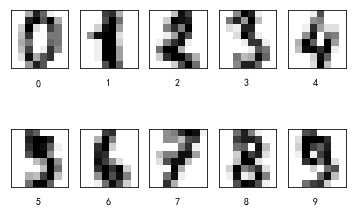

In [223]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [224]:
# Split the data into training set and test set 
X_train, X_test, Y_train, Y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [225]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

Y_train[Y_train < 5 ] = 0
Y_train[Y_train >= 5] = 1
Y_test[Y_test < 5] = 0
Y_test[Y_test >= 5] = 1

In [226]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


In [227]:
print (np.max(X_train))
print (np.min(X_train))
print (np.max(Y_train))
print (np.min(Y_train))

16.0
0.0
1
0


In [228]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [229]:
print (np.max(X_train),np.min(X_train))
print (np.max(X_train_scaled),np.min(X_train_scaled), np.std(X_train_scaled), np.mean(X_train_scaled))
print (np.max(X_test_scaled),np.min(X_test_scaled))

36.6878726556887 -3.054215700358607
36.6878726556887 -2.9537914002306684 0.9762812094883325 -1.512441908082526e-17
51.903771413924815 -2.9537914002306684


#### 3- Architecture of the neural network

![title](network.png)

##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [230]:
import numpy as np
import math
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    #s = None
    #s = list(map(lambda x: 1 / (1 + np.exp(-x)), z))
    s = 1/(1+np.exp(-1*z))
    return s

In [231]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))
print (type(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]
<class 'numpy.ndarray'>


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [232]:
# Random innitialize the parameters
def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    #w = np.zeros((m, 1))
    #b = 0
    w = np.random.uniform(0, 0.001,size=(dim,1))
    #b = 0.0001
    b = np.random.uniform(0, 0.001)
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    #print ('w and b initilized')
    #print ('w shape is ', w.shape)
    
    return w,b

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X   

activate linear inputs :  . A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)})$    
Los function : . J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}loga^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [233]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    #m = X.shape[1]
    #w,b = initialize_parameters(m)
    #A = sigmoid(w.T*X + b)
    #A=sigmoid(np.dot(X,w) +b)
    #A = sigmoid(np.dot(w.T,X)+b)
    #cost = (-1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
    
    #dw = (1/m)*np.dot(X,(A-Y).T)
    #db = (1/m)*np.sum(A-Y)
    
    m = X.shape[1]
    w,b = initialize_parameters(m)
    #A = sigmoid(w.T*X + b)
    A=sigmoid(np.dot(X,w) +b)
    #A=sigmoid(np.dot(w.T,X.T)+b)
    #A = sigmoid(np.dot(w.T,X)+b)
    cost = (-1/m)*np.sum(np.dot(Y,np.log(A))+ np.dot((1-Y), np.log(1-A)))

    #cost = (-1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
    #print ('cost is', cost)
    #print ('X shape is :', X.shape)
    #print ('A shape is :', A.shape)
    #print ('Y shape is :', Y.shape)

    dw = (1/m)*np.dot(X.T,np.subtract(A,Y.T))
    #print ('dw shape is :', dw.shape)
    db = (1/m)*np.sum(np.subtract(A,Y.T))
    #print ('db is :', db)
    
    #assert(dw.shape == w.shape)
    #assert(db.dtype == float)
    cost = np.squeeze(cost)
    #assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    #print ('grads, cost calcualted')
    return grads, cost

<font color='red'>
    
### 问题1： 是不是不能直接 Y*np.log(A) 这样子乘， 一定要用np.dot? 
### 问题2： 是不是用A对应 cost 1 或者   B对应cost 2 这两种计算方法都可以？ cost1 和cost2 算出来是一样的。

In [234]:
X=X_train
Y=Y_train
m = X.shape[1]
w,b = initialize_parameters(m)
#A = sigmoid(w.T*X + b)
A=sigmoid(np.dot(X,w) +b)
#A = sigmoid(np.dot(w.T,X)+b)
B=sigmoid(np.dot(w.T,X.T)+b)

cost = (-1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
cost1 = (-1/m)*np.sum(np.dot(Y,np.log(A))+ np.dot((1-Y), np.log(1-A)))
cost2= (-1/m)*np.sum(Y*np.log(B)+(1-Y)*np.log(1-B))
print ('cost', cost)
print ('cost1', cost1)
print ('cost2', cost2)
print ('X shape is :', X.shape)
print ('w shape is :', w.shape)
print ('A shape is :', A.shape)
print ('B shape is :', B.shape)
print ('Y shape is :', Y.shape)

cost 19651.042551482475
cost1 14.587667741385712
cost2 14.587667741385712
X shape is : (1347, 64)
w shape is : (64, 1)
A shape is : (1347, 1)
B shape is : (1, 1347)
Y shape is : (1347,)


##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [242]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    costs = []
    
    for i in range(num_iterations):
        #print (i, 'th iteration')
        
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads['dw']
        #print ('dw is ', dw)
        db = grads['db']
        #print ('db is ', db)
        
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    #print ('params is', params)
    #print ('grads is', grads)

    return params, grads, costs

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [236]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[0]
    #print (X.shape)
    #print ('m is :', m)
    Y_prediction = np.zeros((1,m))
    print (Y_prediction.shape)
    #print ('X.shape[0] is :', X.shape[0])
    #print ('w shape is ', w.shape)
   
    #A = sigmoid(np.dot(w.T, X) + b)
    A = sigmoid(np.dot(X,w) +b)
    #A = sigmoid((w.T*X))
    #print ('A.shape is ', A.shape)
    #print (A)
    #print (A[0,0])
    #print (A[1,0])
    print ('A shape is :', A.shape)
    for i in range(A.shape[0]):
        #print (A)
        #print ('A[i,0] is :', A[i,0])
        if(A[i,0]<=0.5):
            Y_prediction[0,i]=0
        else:
            Y_prediction[0,i]=1 
    print ('Y_prediction.shape is: ', Y_prediction.shape)
    assert(Y_prediction.shape == (1,m))
    return Y_prediction


##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [237]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    #Step by step call to other functions
    
    #Initialization
    w, b = initialize_parameters(X_train.shape[1])
    print ('w and b initialized')
    
    #Gradient Descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train,num_iterations = num_iterations, learning_rate = learning_rate, print_cost = True)
    
    w = parameters["w"]
    b = parameters["b"]
    
    print ('w got')
    print ('b got')
    
    # Predict test/train set examples
    Y_prediction_train = predict(w,b,X_train)
    print ('Y_prediction_train got')
    Y_prediction_test = predict(w,b,X_test)
    print ('Y_prediction_test got')
    
    print ('Y_prediction_train.shape is ', Y_prediction_train.shape)
    print ('Y_train.shape is ', Y_train.shape)
    
    # Print train/test Errors
    #print("train accuracy: {} %".format(100 - np.mean(np.abs(np.subtract(Y_prediction_train,Y_train)) * 100)))
    #print("test accuracy: {} %".format(100 - np.mean(np.abs(np.subtract(Y_prediction_test,Y_test)) * 100)))
    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the learning process.   


In [238]:
Y_train= np.expand_dims(Y_train, axis=0)
Y_test= np.expand_dims(Y_test, axis=0)

##### double check to make sure both X_train and X_test has been normalized 

In [239]:
print (np.max(X_train),np.min(X_train), np.std(X_train_scaled), np.mean(X_train_scaled))
print (np.max(X_test),np.min(X_test), np.std(X_test_scaled), np.mean(X_test_scaled))

36.6878726556887 -3.054215700358607 0.9762812094883325 -1.512441908082526e-17
92.86897089937645 -3.054215700358607 1.0267194506578998 0.004445147895461681


<font color='red'>

用2000个interation test了 learning rate =0.1， 0.01， 0.001, cost和 最后model的准确率都没有变
用10000 和20000个interation learning rate =0.01 test， cost和最后model的准确率也基本没有变

问题： 是因为logistic regression model相对来说比较简单，所以 interation 和 learning rate 都对model 影响不大吗？

w and b initialized
Cost after iteration 0: 14.591689
Cost after iteration 100: 14.587565
Cost after iteration 200: 14.594893
Cost after iteration 300: 14.588268
Cost after iteration 400: 14.592882
Cost after iteration 500: 14.587729
Cost after iteration 600: 14.592037
Cost after iteration 700: 14.590687
Cost after iteration 800: 14.590829
Cost after iteration 900: 14.586819
Cost after iteration 1000: 14.590740
Cost after iteration 1100: 14.594276
Cost after iteration 1200: 14.594153
Cost after iteration 1300: 14.585795
Cost after iteration 1400: 14.590097
Cost after iteration 1500: 14.590625
Cost after iteration 1600: 14.594627
Cost after iteration 1700: 14.592659
Cost after iteration 1800: 14.588815
Cost after iteration 1900: 14.589520
w got
b got
(1, 1347)
A shape is : (1347, 1)
Y_prediction.shape is:  (1, 1347)
Y_prediction_train got
(1, 450)
A shape is : (450, 1)
Y_prediction.shape is:  (1, 450)
Y_prediction_test got
Y_prediction_train.shape is  (1, 1347)
Y_train.shape is  (1, 134

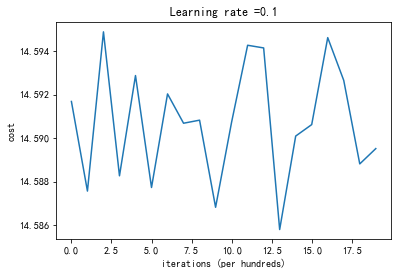

In [249]:
d=model(X_train, Y_train, X_test, Y_test, 2000, learning_rate=0.1,print_cost=True)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

w and b initialized
Cost after iteration 0: 14.589123
Cost after iteration 100: 14.587078
Cost after iteration 200: 14.586027
Cost after iteration 300: 14.586173
Cost after iteration 400: 14.592500
Cost after iteration 500: 14.588117
Cost after iteration 600: 14.591943
Cost after iteration 700: 14.590059
Cost after iteration 800: 14.592285
Cost after iteration 900: 14.592008
Cost after iteration 1000: 14.588840
Cost after iteration 1100: 14.586934
Cost after iteration 1200: 14.596405
Cost after iteration 1300: 14.590772
Cost after iteration 1400: 14.588068
Cost after iteration 1500: 14.592699
Cost after iteration 1600: 14.590522
Cost after iteration 1700: 14.586977
Cost after iteration 1800: 14.590031
Cost after iteration 1900: 14.591906
w got
b got
(1, 1347)
A shape is : (1347, 1)
Y_prediction.shape is:  (1, 1347)
Y_prediction_train got
(1, 450)
A shape is : (450, 1)
Y_prediction.shape is:  (1, 450)
Y_prediction_test got
Y_prediction_train.shape is  (1, 1347)
Y_train.shape is  (1, 134

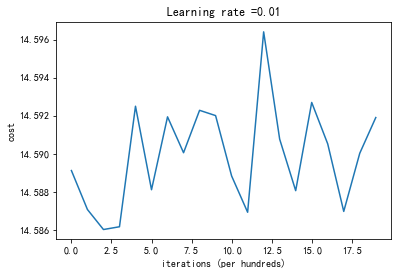

In [248]:
d=model(X_train, Y_train, X_test, Y_test, 2000, learning_rate=0.01,print_cost=True)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

w and b initialized
Cost after iteration 0: 14.594401
Cost after iteration 100: 14.583002
Cost after iteration 200: 14.595891
Cost after iteration 300: 14.594366
Cost after iteration 400: 14.590437
Cost after iteration 500: 14.587982
Cost after iteration 600: 14.588202
Cost after iteration 700: 14.596100
Cost after iteration 800: 14.598533
Cost after iteration 900: 14.590908
Cost after iteration 1000: 14.590543
Cost after iteration 1100: 14.589902
Cost after iteration 1200: 14.593955
Cost after iteration 1300: 14.587036
Cost after iteration 1400: 14.592303
Cost after iteration 1500: 14.590805
Cost after iteration 1600: 14.589499
Cost after iteration 1700: 14.587558
Cost after iteration 1800: 14.587405
Cost after iteration 1900: 14.590795
w got
b got
(1, 1347)
A shape is : (1347, 1)
Y_prediction.shape is:  (1, 1347)
Y_prediction_train got
(1, 450)
A shape is : (450, 1)
Y_prediction.shape is:  (1, 450)
Y_prediction_test got
Y_prediction_train.shape is  (1, 1347)
Y_train.shape is  (1, 134

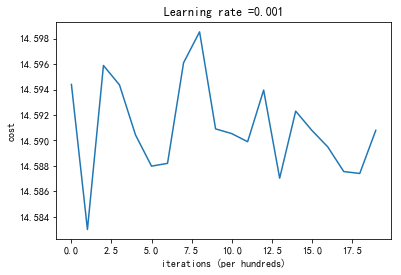

In [247]:
d=model(X_train, Y_train, X_test, Y_test, 2000, learning_rate=0.001,print_cost=True)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

##### 4.2 Observe the effect of iteration_num on the test accuracy.

In [251]:
d=model(X_train, Y_train, X_test, Y_test, 10000, learning_rate=0.01,print_cost=True)

w and b initialized
Cost after iteration 0: 14.589150
Cost after iteration 100: 14.590468
Cost after iteration 200: 14.594859
Cost after iteration 300: 14.587521
Cost after iteration 400: 14.599617
Cost after iteration 500: 14.593762
Cost after iteration 600: 14.589738
Cost after iteration 700: 14.589238
Cost after iteration 800: 14.583861
Cost after iteration 900: 14.590264
Cost after iteration 1000: 14.590033
Cost after iteration 1100: 14.592379
Cost after iteration 1200: 14.591404
Cost after iteration 1300: 14.584073
Cost after iteration 1400: 14.588151
Cost after iteration 1500: 14.593820
Cost after iteration 1600: 14.589060
Cost after iteration 1700: 14.595069
Cost after iteration 1800: 14.590739
Cost after iteration 1900: 14.592855
Cost after iteration 2000: 14.590325
Cost after iteration 2100: 14.584180
Cost after iteration 2200: 14.596835
Cost after iteration 2300: 14.592567
Cost after iteration 2400: 14.586196
Cost after iteration 2500: 14.595796
Cost after iteration 2600: 14.

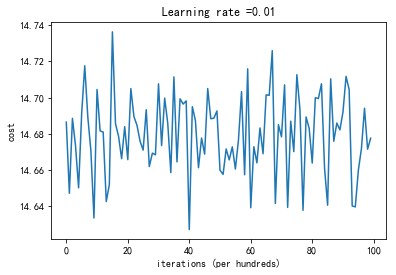

In [41]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [255]:
d=model(X_train, Y_train, X_test, Y_test, 20000, learning_rate=0.01,print_cost=True)

w and b initialized
Cost after iteration 0: 14.590508
Cost after iteration 100: 14.593181
Cost after iteration 200: 14.593728
Cost after iteration 300: 14.594141
Cost after iteration 400: 14.586182
Cost after iteration 500: 14.589978
Cost after iteration 600: 14.590177
Cost after iteration 700: 14.593136
Cost after iteration 800: 14.589355
Cost after iteration 900: 14.596956
Cost after iteration 1000: 14.590957
Cost after iteration 1100: 14.585965
Cost after iteration 1200: 14.592477
Cost after iteration 1300: 14.589195
Cost after iteration 1400: 14.591969
Cost after iteration 1500: 14.594709
Cost after iteration 1600: 14.597436
Cost after iteration 1700: 14.593036
Cost after iteration 1800: 14.588153
Cost after iteration 1900: 14.593180
Cost after iteration 2000: 14.589353
Cost after iteration 2100: 14.595574
Cost after iteration 2200: 14.589500
Cost after iteration 2300: 14.594747
Cost after iteration 2400: 14.592743
Cost after iteration 2500: 14.584410
Cost after iteration 2600: 14.

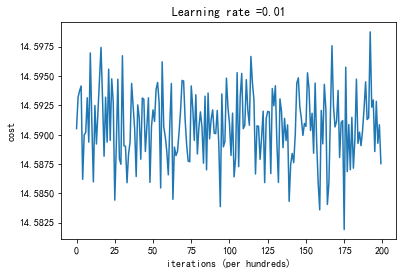

In [256]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [260]:
d['Y_prediction_test']

array([[1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
        1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0.,
        1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
        1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 

In [263]:
print (np.sum(Y_test))
print (Y_test.shape)

236
(1, 450)


# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digits (0,1,2,3,4,5,6,7,8,9) is in the image.

# Congratulations ! You have completed assigment 4. 